In [1]:
!pip install imbalanced-learn &> /dev/null
!pip install smote-variants &> /dev/null

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statistics as s
from sklearn.impute import KNNImputer
## Will delete if not req
from numpy import math


from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.model_selection import cross_validate,RepeatedStratifiedKFold,cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve,precision_recall_curve
from sklearn.metrics import roc_auc_score,recall_score,precision_score
import smote_variants as sv
from sklearn.svm import SVC

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier

##used to ignore warning messages
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv("/content/drive/MyDrive/Almabetter learning/Cardiovascular Risk Prediction/data_cardiovascular_risk.csv")
print("Dataset size")
print("Rows {} Columns {}".format(data.shape[0], data.shape[1]))

Dataset size
Rows 3390 Columns 17


In [5]:
data.sample(5)

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
2723,2723,43,4.0,M,YES,NaN,0.0,0,0,0,222.0,109.5,69.0,25.50,75.0,NaN,0
2749,2749,55,1.0,F,NO,0.0,0.0,0,0,0,215.0,122.0,86.0,30.61,79.0,87.0,0
2801,2801,45,4.0,M,NO,0.0,0.0,0,0,0,221.0,105.0,70.0,23.95,52.0,83.0,0
1035,1035,62,4.0,M,NO,0.0,0.0,0,0,0,273.0,129.0,83.0,25.49,63.0,70.0,0
3342,3342,39,1.0,F,NO,0.0,0.0,0,0,0,214.0,123.0,78.0,38.06,66.0,62.0,0


In [6]:
# Id dropped as not req
data.drop(columns=['id'],inplace=True)

Data Analysis

In [7]:
data.columns

Index(['age', 'education', 'sex', 'is_smoking', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD'],
      dtype='object')

In [8]:
data.isna().sum()

age                  0
education           87
sex                  0
is_smoking           0
cigsPerDay          22
BPMeds              44
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             38
sysBP                0
diaBP                0
BMI                 14
heartRate            1
glucose            304
TenYearCHD           0
dtype: int64

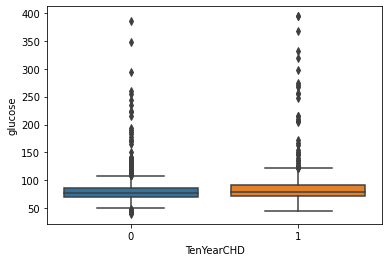

In [9]:
sns.boxplot(data=data,x='TenYearCHD',y='glucose');

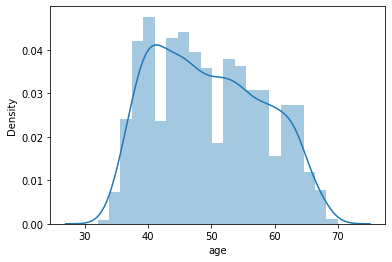

In [10]:
sns.distplot(data['age']);

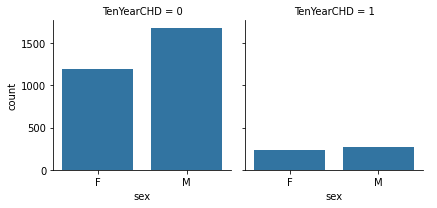

In [11]:
fct=sns.FacetGrid(data=data,col='TenYearCHD')
# map the above form facetgrid with some attributes
fct.map(sns.countplot,'sex').add_legend()
# show the object
plt.show()

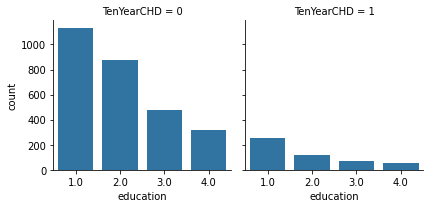

In [12]:

fct=sns.FacetGrid(data=data,col='TenYearCHD')
# map the above form facetgrid with some attributes
fct.map(sns.countplot,'education').add_legend()
# show the object
plt.show()

In [13]:
data['education'].describe()

count    3303.000000
mean        1.970936
std         1.019081
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         4.000000
Name: education, dtype: float64

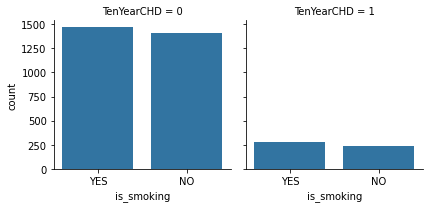

In [14]:
fct=sns.FacetGrid(data=data,col='TenYearCHD')
# map the above form facetgrid with some attributes
fct.map(sns.countplot,'is_smoking').add_legend()
# show the object
plt.show()

In [15]:
data['prevalentStroke'].describe()

count    3390.000000
mean        0.006490
std         0.080309
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: prevalentStroke, dtype: float64

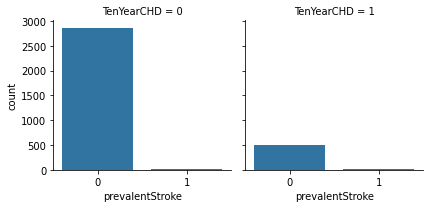

In [16]:
fct=sns.FacetGrid(data=data,col='TenYearCHD')
# map the above form facetgrid with some attributes
fct.map(sns.countplot,'prevalentStroke').add_legend()
# show the object
plt.show()

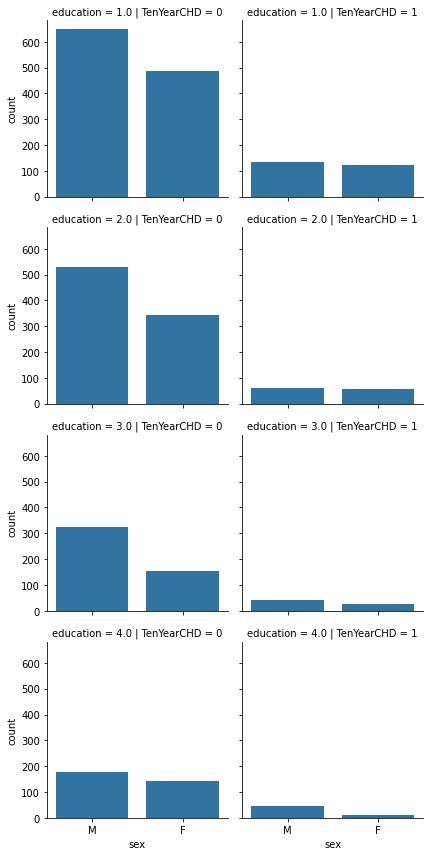

In [17]:
fct=sns.FacetGrid(data=data,col='TenYearCHD',row='education')
# map the above form facetgrid with some attributes
fct.map(sns.countplot,'sex').add_legend()
# show the object
plt.show()

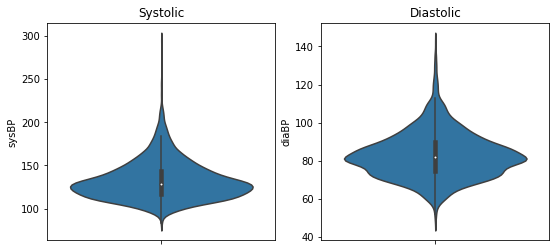

In [18]:
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
sns.violinplot(data=data,y='sysBP')
plt.title("Systolic")
plt.subplot(1,2,2)
sns.violinplot(data=data,y='diaBP',)
plt.title("Diastolic")
#plt.legends()
plt.show()

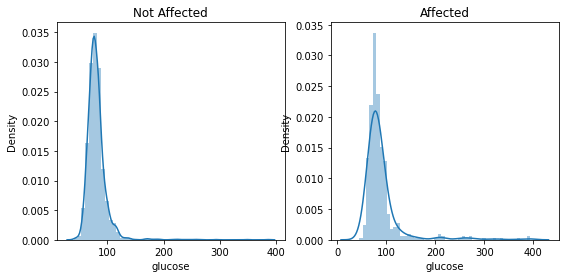

In [19]:
#sns.distplot(data['glucose']);
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
sns.distplot(data[data['TenYearCHD']==0]['glucose']);
plt.title("Not Affected")
plt.subplot(1,2,2)
sns.distplot(data[data['TenYearCHD']==1]['glucose']);
plt.title("Affected")
#plt.legends()
plt.show()

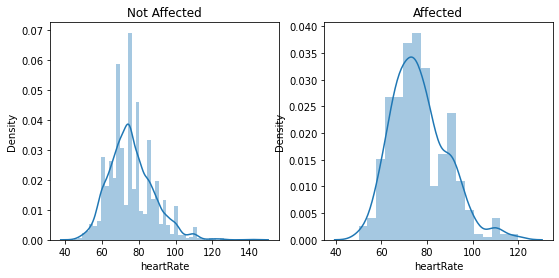

In [20]:
#sns.distplot(data['glucose']);
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
sns.distplot(data[data['TenYearCHD']==0]['heartRate']);
plt.title("Not Affected")
plt.subplot(1,2,2)
sns.distplot(data[data['TenYearCHD']==1]['heartRate']);
plt.title("Affected")
#plt.legends()
plt.show()

Handling Null Values

In [21]:
data[data['glucose'].isna()]['diabetes'].value_counts()

0    301
1      3
Name: diabetes, dtype: int64

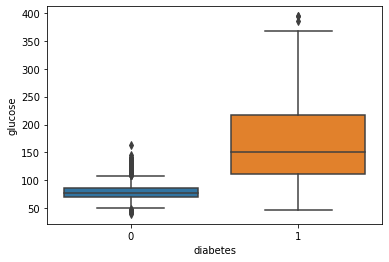

In [22]:
sns.boxplot(data=data,x='diabetes',y='glucose');

In [23]:
## Null handling for column glucose
data.loc[(data['glucose'].isna()) & (data['diabetes']==0) ,['glucose'] ]=data[data['diabetes']==0]['glucose'].median()
data.loc[(data['glucose'].isna()) & (data['diabetes']==1) ,['glucose'] ]=data[data['diabetes']==1]['glucose'].median()

In [24]:
# Imputed null values with mode
data['BPMeds']=data['BPMeds'].fillna(s.mode(data['BPMeds']))

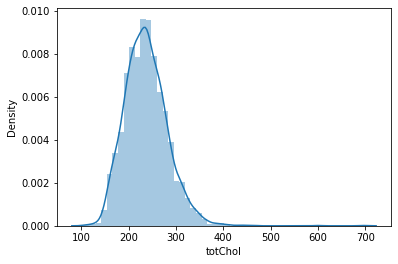

In [25]:
sns.distplot(data['totChol']);

In [26]:
# Less than 400 almost Normal, impute with mean
data['totChol']=data['totChol'].fillna(data['totChol'].median())

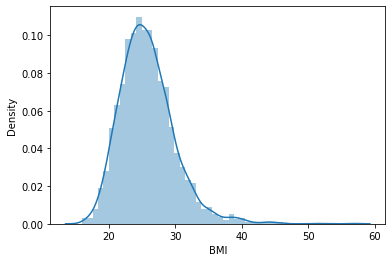

In [27]:
sns.distplot(data['BMI']);

In [28]:
# Less than 36 almost Normal, impute with mean
data['BMI']=data['BMI'].fillna(data['BMI'].median())

In [29]:
## CigsPerDay 22 nulls needs imputation as is_smoking is yes all 22 records
data[(data.cigsPerDay.isna()) & (data.is_smoking!='YES')]

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD


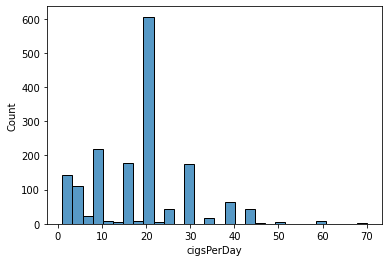

In [30]:
#data['cigsPerDay'].value_counts()

sns.histplot(data[data['cigsPerDay']!=0]['cigsPerDay'],bins=30);
## Bar plot gives an idea about what count of cigsperday is observed in more numbers

In [31]:
data['cigsPerDay']=data['cigsPerDay'].fillna(np.random.randint(5,30))

In [32]:
data['heartRate']=data['heartRate'].fillna(np.mean(data['heartRate']))

In [33]:
data.head()

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,64,2.0,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,25.38,90.0,80.0,1
1,36,4.0,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,46,1.0,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,50,1.0,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,64,1.0,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


In [34]:
# Encoding this categorical to prepare data for KNN impute
data['is_smoking']=data['is_smoking'].apply(lambda x:1 if x=='YES' else 0)
data['sex']=data['sex'].apply(lambda x:1 if x=='M' else 0)

In [35]:
#data.drop(['glucose'],inplace=True,axis=1)

In [36]:
data.isna().sum()

age                 0
education          87
sex                 0
is_smoking          0
cigsPerDay          0
BPMeds              0
prevalentStroke     0
prevalentHyp        0
diabetes            0
totChol             0
sysBP               0
diaBP               0
BMI                 0
heartRate           0
glucose             0
TenYearCHD          0
dtype: int64

In [37]:
#data[data['glucose'].isna()]
# define imputer
imputer = KNNImputer(n_neighbors=10, weights='uniform', metric='nan_euclidean')

In [38]:
# fit on the dataset
imputer.fit(data)

KNNImputer(n_neighbors=10)

In [39]:
# transform the dataset
data_trans = pd.DataFrame(imputer.transform(data),columns=data.columns)

In [40]:
data_trans.isna().sum().sum()

0

In [41]:
data=data_trans.copy()

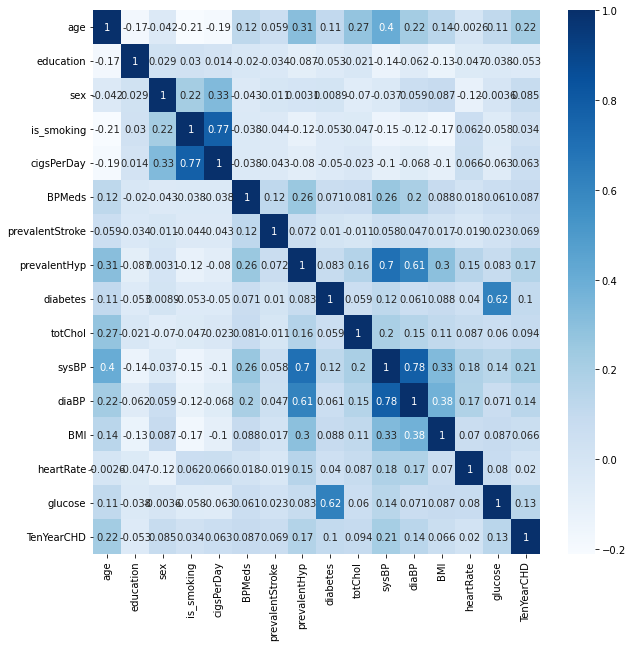

In [42]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(),annot=True,cmap='Blues');

In [43]:

X=data.drop(['TenYearCHD'],axis=1).values
y=data['TenYearCHD'].values

In [44]:
# handling data imbalance
oversampler= sv.distance_SMOTE()
X_msmote, y_msmote= oversampler.sample(X, y)

2021-12-25 05:12:58,354:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


In [45]:
data_new=pd.DataFrame(X_msmote,columns=data.columns[:-1])
data_new['TenYearCHD']=pd.DataFrame(y_msmote)
data_new['TenYearCHD'].value_counts()

0.0    2879
1.0    2879
Name: TenYearCHD, dtype: int64

In [46]:
X=data_new.drop(['TenYearCHD'],axis=1)
y=data_new['TenYearCHD']

In [47]:
#X.drop(['is_smoking','education'],axis=1,inplace=True)

In [48]:
X['pulse']=X['sysBP']-X['diaBP']
X.drop(['sysBP','diaBP'],axis=1,inplace=True)

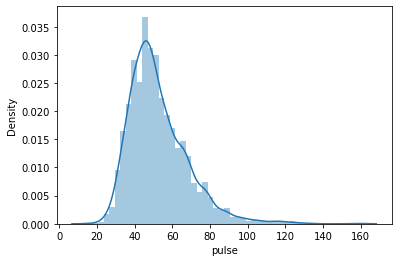

In [49]:
sns.distplot(X['pulse'])

In [50]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=10)

In [51]:
# Scaling the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [52]:
## Define the logistic model
logistic = LogisticRegression(random_state=30)

In [53]:
scoring = ['roc_auc']
scores = cross_validate(logistic,X, y, scoring = scoring, cv = 5, return_train_score=True,return_estimator=True,verbose = 10);

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] START .....................................................................
[CV] END ................. roc_auc: (train=0.714, test=0.702) total time=   0.2s
[CV] START .....................................................................
[CV] END ................. roc_auc: (train=0.716, test=0.695) total time=   0.2s
[CV] START .....................................................................
[CV] END ................. roc_auc: (train=0.704, test=0.743) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s


[CV] END ................. roc_auc: (train=0.711, test=0.716) total time=   0.1s
[CV] START .....................................................................
[CV] END ................. roc_auc: (train=0.699, test=0.674) total time=   0.1s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished


In [54]:
scores

{'estimator': [LogisticRegression(random_state=30),
  LogisticRegression(random_state=30),
  LogisticRegression(random_state=30),
  LogisticRegression(random_state=30),
  LogisticRegression(random_state=30)],
 'fit_time': array([0.17268229, 0.15259051, 0.11806846, 0.12909365, 0.12870884]),
 'score_time': array([0.00527811, 0.00535893, 0.00514269, 0.00519085, 0.00520015]),
 'test_roc_auc': array([0.70247697, 0.69480312, 0.74288375, 0.71554046, 0.67418176]),
 'train_roc_auc': array([0.71408755, 0.71575108, 0.70397972, 0.71128069, 0.69865242])}

In [55]:
logistic.fit(X_train,y_train)

LogisticRegression(random_state=30)

In [56]:
# Get the predicted class
train_preds = logistic.predict(X_train)
test_preds = logistic.predict(X_test)
cm = confusion_matrix(y_test, test_preds)
print(cm)

[[483 254]
 [211 492]]


In [57]:
## Calc Precision and recall


roc_auc = roc_auc_score(y_test, test_preds)
print(roc_auc)
precision = precision_score(y_test, test_preds)
recall = recall_score(y_test, test_preds)
print("Precision")
print(precision)
print("Recall")
print(recall)
print("F1-Score")
print(2*precision*recall/(recall+precision))

0.6776086591483292
Precision
0.6595174262734584
Recall
0.6998577524893315
F1-Score
0.6790890269151139


In [58]:
# Get the predicted probabilities
train_preds = logistic.predict_proba(X_train)
test_preds = logistic.predict_proba(X_test)

train_preds_df=pd.DataFrame(train_preds,columns=['No','Yes'])
train_preds=np.array(train_preds_df['Yes'])

test_preds_df=pd.DataFrame(test_preds,columns=['No','Yes'])
test_preds=np.array(test_preds_df['Yes'])

Best Threshold=0.514700, G-Mean=0.688
  


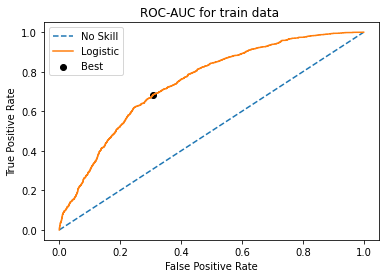

In [59]:
## Calculate optimal threshold using roc_curve method
fpr, tpr, thresholds = roc_curve(y_train, train_preds)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
print("  ")
plt.title("ROC-AUC for train data ")
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, label='Logistic')# marker='.'
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [60]:
test_preds_new=np.array(test_preds_df['Yes'].apply(lambda x:1 if x>=thresholds[ix] else 0))
test_preds_new=np.array(test_preds_df['Yes'].apply(lambda x:1 if x>=thresholds[ix] else 0))

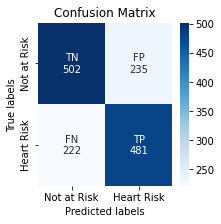

In [61]:
# Get the confusion matrix for test
plt.figure(figsize=(3,3))
labels = ['Not at Risk','Heart Risk' ]
#cm = confusion_matrix(y_test, test_preds_new)
cm = confusion_matrix(y_test, test_preds_new)

cat = ['TN','FP','FN','TP']
#cat = np.asarray(labels2).reshape(2,2)
counts = [count for count in cm.flatten()]
labelsIn = [f"{v1}\n{v2}" for v1, v2 in  zip(cat,counts)]

labelsIn = np.asarray(labelsIn).reshape(2,2)

ax= plt.subplot()
sns.heatmap(cm, annot=labelsIn, ax = ax,fmt='', cmap='Blues');

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels);
ax.yaxis.set_ticklabels(labels);

In [62]:
## Calc Precision and recall
roc_auc = roc_auc_score(y_test, test_preds_new)
print(roc_auc)
precision = precision_score(y_test, test_preds_new)
recall = recall_score(y_test, test_preds_new)
print(precision)
print("\n")
print(recall)
print("F1-Score")
print(2*precision*recall/(recall+precision))

0.6826751410412055
0.6717877094972067


0.6842105263157895
F1-Score
0.6779422128259337


Tuning the logistic model

In [63]:
grid={
'C':[100, 10, 5,1.0, 0.1, 0.01],
'penalty':['none', 'l1', 'l2', 'elasticnet'],
'solver':['newton-cg', 'lbfgs', 'sag', 'saga']
}
logistic = LogisticRegression(random_state=10)

In [64]:

grid_search = GridSearchCV(estimator=logistic, param_grid=grid, n_jobs=-1, scoring='roc_auc',cv=5,error_score=0)
grid_result = grid_search.fit(X_train, y_train)

In [65]:
# import sklearn
# print(sorted(sklearn.metrics.SCORERS.keys()))

In [66]:
C=grid_result.best_params_['C']
penalty=grid_result.best_params_['penalty']
solver=grid_result.best_params_['solver']
grid_result.best_params_

{'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}

In [67]:
tuned_logistic=LogisticRegression(C=C, penalty=penalty,solver=solver,random_state=1)
tuned_logistic.fit(X_train,y_train)

LogisticRegression(C=0.01, random_state=1, solver='saga')

In [68]:
# Get the predicted probabilities
train_preds = tuned_logistic.predict(X_train)
test_preds = tuned_logistic.predict(X_test)

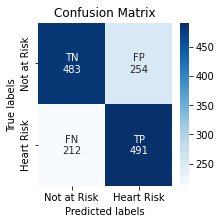

In [69]:
# Get the confusion matrix for test
plt.figure(figsize=(3,3))
labels = ['Not at Risk','Heart Risk' ]
cm = confusion_matrix(y_test, test_preds)

cat = ['TN','FP','FN','TP']
#cat = np.asarray(labels2).reshape(2,2)
counts = [count for count in cm.flatten()]
labelsIn = [f"{v1}\n{v2}" for v1, v2 in  zip(cat,counts)]

labelsIn = np.asarray(labelsIn).reshape(2,2)

ax= plt.subplot()
sns.heatmap(cm, annot=labelsIn, ax = ax,fmt='', cmap='Blues');

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels);
ax.yaxis.set_ticklabels(labels);

In [70]:
## Calc Precision and recall
roc_auc = roc_auc_score(y_test, test_preds_new)
print(roc_auc)
print("")

precision = precision_score(y_test, test_preds_new)
recall = recall_score(y_test, test_preds_new)
print("Precision")
print(precision)
print("Recall")
print(recall)
print(2*precision*recall/(recall+precision))
print("")
accuracy = accuracy_score(y_test, test_preds_new)
print(accuracy)

0.6826751410412055

Precision
0.6717877094972067
Recall
0.6842105263157895
0.6779422128259337

0.6826388888888889


# Support Vector Classifier

In [71]:
clf = SVC(kernel='rbf', C=1E6,random_state=1)
clf.fit(X_train, y_train)

SVC(C=1000000.0, random_state=1)

In [72]:
y_pred_svc=clf.predict(X_test)

In [73]:
cm = confusion_matrix(y_test, y_pred_svc)
print(cm)

[[595 142]
 [ 80 623]]


In [74]:
precision = precision_score(y_test, y_pred_svc)
recall = recall_score(y_test, y_pred_svc)
print(precision)
print(recall)
print(2*precision*recall/(recall+precision))
print("")
accuracy = accuracy_score(y_test, y_pred_svc)
print(accuracy)

0.8143790849673203
0.8862019914651493
0.8487738419618528

0.8458333333333333


In [75]:
clf = SVC(kernel='rbf', C=1E6,random_state=1,probability=True)
clf.fit(X_train, y_train)

SVC(C=1000000.0, probability=True, random_state=1)

In [76]:
train_preds=clf.predict_proba(X_train)
test_preds=clf.predict_proba(X_test)

In [77]:
## Calc threshold from training data
train_preds_df=pd.DataFrame(train_preds,columns=['No','Yes'])
train_preds=np.array(train_preds_df['Yes'])

## For test data
test_preds_df=pd.DataFrame(test_preds,columns=['No','Yes'])
test_preds=np.array(test_preds_df['Yes'])

In [78]:
train_preds

array([9.95073394e-01, 1.00000000e+00, 1.46462784e-05, ...,
       1.86857723e-03, 9.69543456e-01, 1.99935571e-01])

Best Threshold=0.517414, G-Mean=1.000


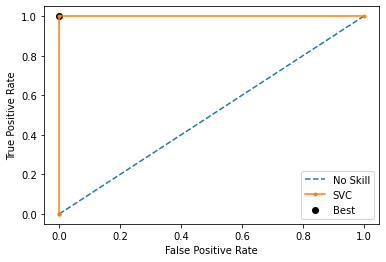

In [79]:
## Calculate optimal threshold using roc_curve method
fpr, tpr, thresholds = roc_curve(y_train, train_preds)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))


# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, label='SVC' , marker='.')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [80]:
train_preds_new=np.array(train_preds_df['Yes'].apply(lambda x:1 if x>thresholds[ix] else 0))
test_preds_new=np.array(test_preds_df['Yes'].apply(lambda x:1 if x>thresholds[ix] else 0))

[Text(0, 0.5, 'Not at Risk'), Text(0, 1.5, 'Heart Risk')]

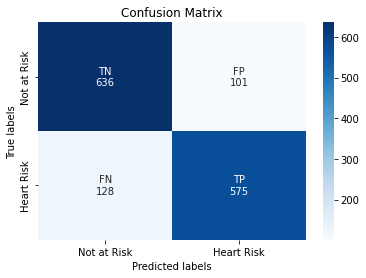

In [81]:
# Get the confusion matrix for test

labels = ['Not at Risk','Heart Risk' ]
cm = confusion_matrix(y_test, test_preds_new)

cat = ['TN','FP','FN','TP']
#cat = np.asarray(labels2).reshape(2,2)
counts = [count for count in cm.flatten()]
labelsIn = [f"{v1}\n{v2}" for v1, v2 in  zip(cat,counts)]

labelsIn = np.asarray(labelsIn).reshape(2,2)

ax= plt.subplot()
sns.heatmap(cm, annot=labelsIn, ax = ax,fmt='', cmap='Blues');

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [82]:
precision = precision_score(y_test, test_preds_new)
recall = recall_score(y_test, test_preds_new)
print(precision)
print(recall)
print(2*precision*recall/(recall+precision))
print("")
accuracy = accuracy_score(y_test, test_preds_new)
print(accuracy)

0.8505917159763313
0.817923186344239
0.8339376359680928

0.8409722222222222


In [83]:
train_preds_class=clf.predict(X_train)
test_preds_class=clf.predict(X_test)
cm = confusion_matrix(y_test, test_preds_class)
cm

array([[595, 142],
       [ 80, 623]])

In [84]:
precision = precision_score(y_test, test_preds_class)
recall = recall_score(y_test, test_preds_class)
print(precision)
print(recall)
print(2*precision*recall/(recall+precision))
print("")
accuracy = accuracy_score(y_test, test_preds_class)
print(accuracy)

0.8143790849673203
0.8862019914651493
0.8487738419618528

0.8458333333333333


# Bagging Classifier

In [85]:
# define models and parameters
model = BaggingClassifier()
n_estimators = [50, 100,500, 1000]
# define grid search
grid = dict(n_estimators=n_estimators)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=5, scoring='roc_auc',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.947223 using {'n_estimators': 500}
0.945484 (0.005112) with: {'n_estimators': 50}
0.946723 (0.006044) with: {'n_estimators': 100}
0.947223 (0.004640) with: {'n_estimators': 500}
0.946903 (0.005308) with: {'n_estimators': 1000}


In [86]:
grid_result.best_params_

{'n_estimators': 500}

In [87]:
clf_bag=BaggingClassifier(n_estimators=grid_result.best_params_['n_estimators'],random_state=10).fit(X_train,y_train)
y_pred_bag=clf_bag.predict(X_test)

In [88]:
cm = confusion_matrix(y_test, y_pred_bag)
print(cm)

[[716  21]
 [112 591]]


In [89]:
precision = precision_score(y_test, y_pred_bag)
recall = recall_score(y_test, y_pred_bag)
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print ("F1-Score {:.3f}".format(2*precision*recall/(recall+precision)))
accuracy =accuracy_score(y_test, y_pred_bag)
print(accuracy)

Precision: 0.966
Recall: 0.841
F1-Score 0.899
0.9076388888888889


Bagging with Logistic

In [90]:
base1 = LogisticRegression(random_state=10)


In [91]:
clf_bag_log1=BaggingClassifier(base_estimator=base1,n_estimators=500,max_samples=3000,random_state=10,bootstrap_features=True,oob_score=True).fit(X_train,y_train)
#clf_bag_log1=BaggingClassifier(base_estimator=base1,n_estimators=500,max_samples=3000,random_state=10,bootstrap_features=True,warm_start=True).fit(X_train,y_train)
y_pred_bag1=clf_bag_log1.predict(X_test)
cm = confusion_matrix(y_test, y_pred_bag1)
print(cm)

## Metrics
precision = precision_score(y_test, y_pred_bag1)
recall = recall_score(y_test, y_pred_bag1)
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print ("F1-Score {:.3f}".format(2*precision*recall/(recall+precision)))
accuracy =accuracy_score(y_test, y_pred_bag1)
print(accuracy)

[[486 251]
 [220 483]]
Precision: 0.658
Recall: 0.687
F1-Score 0.672
0.6729166666666667


In [92]:
from sklearn.ensemble import AdaBoostClassifier

In [93]:

clf_adb = AdaBoostClassifier(random_state=1)
clf_adb.fit(X_train, y_train)

#############
y_pred_adb=clf_adb.predict(X_test)
## Metrics
precision = precision_score(y_test, y_pred_adb)
recall = recall_score(y_test, y_pred_adb)
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print ("F1-Score {:.3f}".format(2*precision*recall/(recall+precision)))
accuracy =accuracy_score(y_test, y_pred_adb)
print(accuracy)


Precision: 0.962
Recall: 0.839
F1-Score 0.897
0.9055555555555556


In [94]:
clf_adb.n_estimators

50

In [95]:
clf_adb.feature_importances_

array([0.08, 0.24, 0.2 , 0.06, 0.06, 0.04, 0.02, 0.12, 0.  , 0.04, 0.02,
       0.04, 0.02, 0.06])

In [102]:

clf_adb_svc = AdaBoostClassifier(random_state=1,base_estimator=SVC(kernel='rbf', C=1E6,random_state=1,probability=True))
clf_adb_svc.fit(X_train, y_train)

# #############
y_pred_adb_svc=clf_adb.predict(X_test)
## Metrics
precision = precision_score(y_test, y_pred_adb_svc)
recall = recall_score(y_test, y_pred_adb_svc)
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print ("F1-Score {:.3f}".format(2*precision*recall/(recall+precision)))
accuracy =accuracy_score(y_test, y_pred_adb_svc)
print(accuracy)


Precision: 0.962
Recall: 0.839
F1-Score 0.897
0.9055555555555556


In [ ]:
# Normal SVC
# [[595 142]
#  [ 80 623]]

In [103]:
# Adaboost SVC
cm = confusion_matrix(y_test, y_pred_adb_svc)
print(cm)

[[714  23]
 [113 590]]


In [97]:
# define models and parameters
model = AdaBoostClassifier(random_state=1)
n_estimators = [10,50, 100,200,500, 800,1000]
# define grid search
grid = dict(n_estimators=n_estimators)
#cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=5, scoring='f1',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.898841 using {'n_estimators': 100}
0.875852 (0.010040) with: {'n_estimators': 10}
0.893785 (0.008216) with: {'n_estimators': 50}
0.898841 (0.009023) with: {'n_estimators': 100}
0.896396 (0.010691) with: {'n_estimators': 200}
0.891200 (0.011151) with: {'n_estimators': 500}
0.892730 (0.007659) with: {'n_estimators': 800}
0.890694 (0.007351) with: {'n_estimators': 1000}


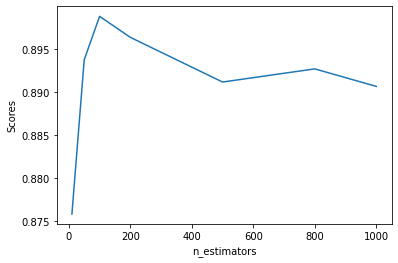

In [98]:
means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['param_n_estimators']
df_scores=pd.DataFrame(zip(means, params),columns=['Scores','n_estimators'])

#plt.ylim(0, 20)
#plt.xlim(10, None)
sns.lineplot(data=df_scores,y='Scores',x='n_estimators',markers='True');

In [99]:
grid_result.cv_results_

{'mean_fit_time': array([0.08738303, 0.4213552 , 0.86170297, 1.6819489 , 4.170788  ,
        6.65418558, 8.10791259]),
 'mean_score_time': array([0.00991044, 0.02606888, 0.04927273, 0.0989964 , 0.23674908,
        0.37960062, 0.43514671]),
 'mean_test_score': array([0.87585213, 0.89378459, 0.89884101, 0.89639621, 0.89120048,
        0.89273042, 0.89069358]),
 'param_n_estimators': masked_array(data=[10, 50, 100, 200, 500, 800, 1000],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 10},
  {'n_estimators': 50},
  {'n_estimators': 100},
  {'n_estimators': 200},
  {'n_estimators': 500},
  {'n_estimators': 800},
  {'n_estimators': 1000}],
 'rank_test_score': array([7, 3, 1, 2, 5, 4, 6], dtype=int32),
 'split0_test_score': array([0.87173101, 0.8902439 , 0.89781022, 0.8902439 , 0.88619855,
        0.88754534, 0.88433735]),
 'split1_test_score': array([0.88943489, 0.90394089, 0.90931373, 0.90

In [104]:
from sklearn.naive_bayes import GaussianNB

In [107]:

clf_adb_NB = AdaBoostClassifier(random_state=1,base_estimator=GaussianNB())
clf_adb_NB.fit(X_train, y_train)

# #############
y_pred_adb_NB=clf_adb_NB.predict(X_test)
## Metrics
precision = precision_score(y_test, y_pred_adb_NB)
recall = recall_score(y_test, y_pred_adb_NB)
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print ("F1-Score {:.3f}".format(2*precision*recall/(recall+precision)))
accuracy =accuracy_score(y_test, y_pred_adb_NB)
print(accuracy)


Precision: 0.492
Recall: 0.996
F1-Score 0.659
0.4965277777777778


In [108]:
# Adaboost SVC
cm = confusion_matrix(y_test, y_pred_adb_NB)
print(cm)

[[ 15 722]
 [  3 700]]
